# Fit phase curve and albedo

In [1]:
last_epoch = 5

In [2]:
import numpy as np
import os
import multiprocessing as mp
import matplotlib
import matplotlib.pyplot as plt

import astropy.io.ascii
import astropy.table
import astropy.units as u
import astropy.constants as c
import astropy.time

#import astroquery.simbad

import orbitize
from orbitize import driver

import pandas as pd
import bem

import exoscene.planet
from exoscene.planet import Planet

import scipy.optimize

#plt.style.use('dark_background')
plt.style.use('bmh')
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['font.sans-serif'] = 'Helvetica'

In [3]:
data_dir = os.path.relpath("./results/")
plot_dir = os.path.join(data_dir, "plots")
print(data_dir)

results


### Select observing epochs to fit

In [4]:
use_epoch_inds = np.arange(last_epoch)
num_epochs = len(use_epoch_inds)
assert(num_epochs > 0)
print(use_epoch_inds)

[0 1 2 3 4]


### True planet system parameters, for reference

In [5]:
star_name = "47 UMa"

#customSimbad = astroquery.simbad.Simbad()
#customSimbad.add_votable_fields('plx', 'plx_error')
#simbad_table = customSimbad.query_object(star_name)
#plx = simbad_table['PLX_VALUE'][0]
#plx_err = simbad_table['PLX_ERROR'][0]

plx = 72.4528
plx_err = 0.1507
scistar_dist = (1 * u.AU / np.tan(plx * u.mas)).to(u.parsec)
scistar_dist_err = ((1 * u.AU / np.tan((plx - plx_err) * u.mas)).to(u.parsec)
                    - (1 * u.AU / np.tan((plx + plx_err) * u.mas)).to(u.parsec)) / 2
print(plx, plx_err, scistar_dist, scistar_dist_err)

72.4528 0.1507 13.802089084203214 pc 0.028708122027220284 pc


In [6]:
system_name = 'official2019v2'

wavelens = np.array([575]) * u.nanometer

T0 = astropy.time.Time('2026-11-01T00:00:00', format='isot', scale='utc') # first epoch

This cell copied directly from the original "planet_orbit_timeseries" notebook

In [7]:
if system_name == 'official2019v2':
#    data_dir = "./data_official2019"

    dist = scistar_dist
    mass_star = 1.0 * c.M_sun
    long_node = 320 * u.deg
    long_node_d = 290 * u.deg

    sma_b = 2.3 * u.AU
    sma_c = 4.24 * u.AU # ~ sma_b * 2.5**(2./3) for 5:2 resonance
    sma_d = 7.7 * u.AU # ~ sma_c * 3.0**(2./3) for 3:1 resonance
    
    mass_b = 0.27 * u.M_jup # approximately Saturn mass
    mass_c = 0.94 * u.M_jup
    mass_d = 0.32 * u.M_jup

    rad_b = 0.8 * u.R_jup
    rad_c = 1.0 * u.R_jup
    rad_d = 0.8 * u.R_jup
    
    albedo_b = 0.3
    albedo_c = 0.4
    albedo_d = 0.5
    
    P_b = np.sqrt( 4 * np.pi**2 / (c.G * (mass_star + mass_b) ) 
                  * sma_b**3 ).to(u.year)
    P_c = np.sqrt( 4 * np.pi**2 / (c.G * (mass_star + mass_c) ) 
                  * sma_c**3 ).to(u.year)
    P_d = np.sqrt( 4 * np.pi**2 / (c.G * (mass_star + mass_d) ) 
                  * sma_d**3 ).to(u.year)
        
    t_peri = -2 * P_c
    t_peri_abs = T0 + t_peri

    argperi_b = (113 * u.deg - 180 * u.deg - 360 * u.deg * (2 * P_c) / P_b) % (360 * u.deg) # wind back argument of periastron 2 * P_c
    argperi_c = 270 * u.deg - 180 * u.deg
    argperi_d = (293 * u.deg - 180 * u.deg - 360 * u.deg * (2 * P_c) / P_d) % (360 * u.deg)

    planetb = Planet('b', dist=dist, a=sma_b, ecc=0.07, inc=55*u.deg, longnode=long_node,
                     argperi=argperi_b, tperi=t_peri, mplan=mass_b,
                     radius = rad_b, albedo_wavelens=wavelens, albedo_vals=[albedo_b])
    
    planetc = Planet('c', dist=dist, a=sma_c, ecc=0.02, inc=57*u.deg, longnode=long_node,
                     argperi=argperi_c, tperi=t_peri, mplan=mass_c,
                     radius = rad_c, albedo_wavelens=wavelens, albedo_vals=[albedo_c])

    planetd = Planet('d', dist=dist, a=sma_d, ecc=0.10, inc=48*u.deg, longnode=long_node_d,
                     argperi=argperi_d, tperi=t_peri, mplan=mass_d,
                     radius = rad_d, albedo_wavelens=wavelens, albedo_vals=[albedo_d])

    planetlist = [planetb, planetc, planetd]


In [8]:
planetc.__dict__

{'name': 'c',
 'dist': <Quantity 13.80208908 pc>,
 'P': <Quantity 8.72694471 yr>,
 'a': <Quantity 4.24 AU>,
 'ecc': 0.02,
 'tperi': <Quantity -17.45388941 yr>,
 'argperi': <Quantity 90. deg>,
 'inc': <Quantity 57. deg>,
 'longnode': <Quantity 320. deg>,
 'albedo_wavelens': <Quantity [575.] nm>,
 'albedo_vals': [0.4],
 'radius': <Quantity 1. jupiterRad>,
 'mstar': <Quantity 1. solMass>,
 'mplan': <Quantity 0.94 jupiterMass>}

In [9]:
true_ecc = planetc.ecc
true_inc = planetc.inc
true_mtot = planetc.mstar
true_sma = planetc.a
true_period = planetc.P
true_mplan = planetc.mplan
true_k = (8.95 * u.centimeter / u.second 
          / np.sqrt(1 - true_ecc ** 2)
          * true_mplan.to(u.M_earth) / u.M_earth * np.sin(true_inc)
          * (true_mtot / u.M_sun) ** (-2./3)
          * (true_period / u.year) ** (-1./3)).to(u.meter / u.second)
print(true_k)

10.894345309161539 m / s

### Load astrometry and photometry measurements

In [10]:
planetc_meas_table_fname = os.path.join(data_dir, "planet_c_in-house.xlsx")
planetc_meas = pd.read_excel(planetc_meas_table_fname, sheet_name="reduced", header=1)
planetc_meas

,epoch,date (JD),flux ratio,flux ratio uncertainty,RA offset (mas),Dec offset (mas),astrometric uncertainty (mas per axis)
0,1,2461345.50,4.822000e-09,7.662177e-10,129.398949,108.993730,5.70
1,2,2461400.29,4.171000e-09,6.858936e-10,143.119385,78.468906,6.80
2,3,2461710.75,3.393000e-09,5.215681e-10,227.900000,-82.800000,3.94
3,4,2462076.00,1.724000e-09,4.353757e-10,209.298258,-245.436090,8.90
4,5,2462441.25,3.761000e-10,2.659429e-10,84.321600,-252.964800,20.80


In [11]:
dates = planetc_meas['date (JD)'][use_epoch_inds].values
raoffs = planetc_meas['RA offset (mas)'][use_epoch_inds].values
decoffs = planetc_meas['Dec offset (mas)'][use_epoch_inds].values
raoff_errs = planetc_meas['astrometric uncertainty (mas per axis)'][use_epoch_inds].values
decoff_errs = raoff_errs
fluxratio_meas = planetc_meas['flux ratio'][use_epoch_inds].values
fluxratio_meas_errs = planetc_meas['flux ratio uncertainty'][use_epoch_inds].values

### Load radvel results

In [12]:
radvel_result_table_fname = os.path.join(data_dir, "radvel_post.csv")
radvel_result = pd.read_csv(radvel_result_table_fname)
radvel_result

,Unnamed: 0,per1,tc1,w1,e1,k1,per2,tc2,w2,e2,k2
0,0.0225,1253.218121,2.464959e+06,-2.938486,0.001200,3.665147,3149.875648,2.456549e+06,-2.629339,0.007930,10.956199
1,0.1600,1260.391236,2.465003e+06,-1.245081,0.008569,3.840519,3176.119083,2.456566e+06,-2.148659,0.027750,11.132145
2,0.5000,1267.812181,2.465047e+06,1.152616,0.029051,4.005668,3206.799274,2.456582e+06,-1.863806,0.048868,11.323114
3,0.8400,1275.810111,2.465095e+06,2.199329,0.061390,4.163734,3295.879707,2.456599e+06,-1.588027,0.071544,11.599916
4,0.9775,1284.104384,2.465144e+06,2.958589,0.101843,4.316773,3332.091076,2.456616e+06,-0.856623,0.091898,11.863424


### Load orbitize results

In [13]:
apply_RV_priors = True
total_orbits = 40000
orbitize_result_table_fname = os.path.join(
        data_dir,
        "planet_c_in-house_orbitize_{:d}epochs_RVpriors{:}_totorb{:06d}.csv".format(
        num_epochs, apply_RV_priors, total_orbits))

orbitize_result = pd.read_csv(orbitize_result_table_fname)
orbitize_result

,sma,inc,ecc,tau,aop,pan,mtot
0,4.141807,51.244255,0.028116,0.641695,36.170179,308.070512,0.935683
1,4.232214,53.522562,0.063448,0.702843,61.920381,312.913460,0.972740
2,4.291902,55.482518,0.092537,0.739761,80.522323,316.783965,0.997354
3,4.355581,57.352751,0.116365,0.772540,95.241907,320.799563,1.024812
4,4.450730,59.809553,0.149197,0.809526,113.046666,324.743993,1.065102


### Define best estimates and lower/upper bounds on relevant planet parameters

In [14]:
# 68% confidence interval
# min_ind = 1
# max_ind = 3
# 95% confidence interval
min_ind = 0
max_ind = 4

k_min = radvel_result['k2'][min_ind] * u.meter / u.second
k_med = radvel_result['k2'][2] * u.meter / u.second
k_max = radvel_result['k2'][max_ind] * u.meter / u.second

sma_min = orbitize_result['sma'][min_ind] * u.AU
sma_med = orbitize_result['sma'][2] * u.AU
sma_max = orbitize_result['sma'][max_ind] * u.AU

ecc_min = orbitize_result['ecc'][min_ind]
ecc_med = orbitize_result['ecc'][2]
ecc_max = orbitize_result['ecc'][max_ind]

inc_min = orbitize_result['inc'][min_ind] * u.deg
inc_med = orbitize_result['inc'][2] * u.deg
inc_max = orbitize_result['inc'][max_ind] * u.deg

aop_min = orbitize_result['aop'][min_ind] * u.deg
aop_med = orbitize_result['aop'][2] * u.deg
aop_max = orbitize_result['aop'][max_ind] * u.deg

pan_min = orbitize_result['pan'][min_ind] * u.deg
pan_med = orbitize_result['pan'][2] * u.deg
pan_max = orbitize_result['pan'][max_ind] * u.deg

tau_min = orbitize_result['tau'][min_ind]
tau_med = orbitize_result['tau'][2]
tau_max = orbitize_result['tau'][max_ind]

mtot_min = orbitize_result['mtot'][min_ind] * u.M_sun
mtot_med = orbitize_result['mtot'][2] * u.M_sun
mtot_max = orbitize_result['mtot'][max_ind] * u.M_sun

period_min = np.sqrt( 4 * np.pi**2 / (c.G * mtot_max)
                        * sma_min**3 ).to(u.day)
period_med = np.sqrt( 4 * np.pi**2 / (c.G * mtot_med)
                        * sma_med**3 ).to(u.day)
period_max = np.sqrt( 4 * np.pi**2 / (c.G * mtot_min)
                        * sma_max**3 ).to(u.day)

print(k_min, k_med, k_max)
print(ecc_min, ecc_med, ecc_max)
print(inc_min, inc_med, inc_max)
print(period_min, period_med, period_max)

10.95619906884271 m / s 11.32311382077273 m / s 11.863423768318494 m / s
0.02811632637450035 0.09253716988394267 0.14919733894263038
51.24425520163544 deg 55.482518273613174 deg 59.809552550896214 deg
2983.2359167273426 d 3251.9841676195883 d 3545.527885195065 d


#### Offset AOP and PAN to match the old scene convention

In [15]:
# old ascending node at planet approach, 0 deg at +x axis
#longnode_min = (pan_min + 270 * u.deg) % (360 * u.deg)
#longnode_med = (pan_med + 270 * u.deg) % (360 * u.deg)
#longnode_max = (pan_max + 270 * u.deg) % (360 * u.deg)
longnode_min = pan_min
longnode_med = pan_med
longnode_max = pan_max

# argument of periastron measured from old ascending node
#argperi_min = (aop_min + 180 * u.deg) % (360 * u.deg)
#argperi_med = (aop_med + 180 * u.deg) % (360 * u.deg)
#argperi_max = (aop_max + 180 * u.deg) % (360 * u.deg)
argperi_min = aop_min
argperi_med = aop_med
argperi_max = aop_max

print(longnode_min, longnode_med, longnode_max)
print(argperi_min, argperi_med, argperi_max)

308.0705119778264 deg 316.7839651798428 deg 324.7439926077201 deg
36.170179014821315 deg 80.52232275400884 deg 113.04666622628253 deg


#### Get periastron time from orbitize $\tau$

In [16]:
# Orbitize defines tau as orbit fraction from Jan 2020
orb_ref_epoch = astropy.time.Time(58849, format='mjd')

orb_tperi_med = orb_ref_epoch + period_med * tau_med
print(orb_tperi_med)

# The old scene defined the periastron as an offset w.r.t. the first observing epoch
tperi_med = (orb_tperi_med - T0).to(u.year)
print(tperi_med)

# Repeat with date offset back by 2 orbit periods
tperi_offset_min = (orb_ref_epoch + period_max * (tau_min - 2) - T0).to(u.year)
tperi_offset_med = (orb_ref_epoch + period_med * (tau_med - 2) - T0).to(u.year)
tperi_offset_max = (orb_ref_epoch + period_min * (tau_max - 2) - T0).to(u.year)

print(tperi_offset_min, tperi_offset_med, tperi_offset_max)
# Compare against true value in original scene
print(planetc.tperi)

61254.68966006342
-0.247256235281532 yr


-20.018918230645838 yr -18.054151061398375 yr -16.5570552789109 yr
-17.453889414202912 yr


### Estimate planet mass from RV semi-amplitude, M_tot, P, sin(i), and ecc 

Use formula from Fischer et al., "Exoplanet Detection Techniques", https://arxiv.org/abs/1505.06869

In [17]:
mplan_min = ((k_min.to(u.cm / u.second) / (8.95 * u.cm / u.second)
             * np.sqrt(1 - ecc_max ** 2) / np.sin(inc_max)
             * (mtot_min.to(u.M_sun) / u.M_sun) ** (2./3) 
             * (period_min.to(u.year) / u.year) ** (1./3))
             * u.M_earth).to(u.M_jup)

mplan_med = ((k_med.to(u.cm / u.second) / (8.95 * u.cm / u.second)
             * np.sqrt(1 - ecc_med ** 2) / np.sin(inc_med)
             * (mtot_med.to(u.M_sun) / u.M_sun) ** (2./3)
             * (period_med.to(u.year) / u.year) ** (1./3))
             * u.M_earth).to(u.M_jup)

mplan_max = ((k_max.to(u.cm / u.second) / (8.95 * u.cm / u.second)
             * np.sqrt(1 - ecc_min ** 2) / np.sin(inc_min)
             * (mtot_max.to(u.M_sun) / u.M_sun) ** (2./3) 
             * (period_max.to(u.year) / u.year) ** (1./3))
             * u.M_earth).to(u.M_jup)

print(mplan_min, mplan_med, mplan_max)

0.8488812195478332 jupiterMass 0.9952505734400702 jupiterMass 1.1893734954823514 jupiterMass


### Estimate the planet equilibrium temperature

Apply Eqn 5 from Laughlin & Lissauer (2015), https://arxiv.org/abs/1501.05685

Stellar parameters from NASA Exoplanet Archive,<br>https://exoplanetarchive.ipac.caltech.edu/applications/Inventory/search.html

In [18]:
Rstar_med = 1.21 * u.R_sun # 1.2075405 +0.0497083/-0.0470408, Gaia DR2
Rstar_min = Rstar_med - 0.05 * u.R_sun
Rstar_max = Rstar_med + 0.05 * u.R_sun

Tstar_med = 5947 * u.K # 5947.000 +119.333/-118.750, Gaia DR2
Tstar_min = Tstar_med - 119 * u.K
Tstar_max = Tstar_med + 119 * u.K

# Bond albedo
bond_A_min = 0.1 # Mercury 
bond_A_med = 0.5 # Jupiter
bond_A_max = 0.8 # Venus

Teq_med = (np.sqrt(Rstar_med / (2 * sma_med)) / (1 - ecc_med ** 2) ** (1./8)
           * Tstar_med * (1 - bond_A_med) ** (1./4)).to(u.K)

Teq_min = (np.sqrt(Rstar_min / (2 * sma_max)) / (1 - ecc_min ** 2) ** (1./8)
           * Tstar_min * (1 - bond_A_max) ** (1./4)).to(u.K)

Teq_max = (np.sqrt(Rstar_max / (2 * sma_min)) / (1 - ecc_max ** 2) ** (1./8)
           * Tstar_max   * (1 - bond_A_min) ** (1./4)).to(u.K)

print(Teq_min, Teq_med, Teq_max)

95.95478447481267 K 128.17649047013109 K 157.582777648532 K


### Estimate planet radius from the BEM mass-radius model

In [19]:
# Load exoplanet and solar system planets dataset
dataset = bem.load_dataset()
# Plot the dataset radius as a function of mass and equilibrium temperature
#bem.plot_dataset(dataset)


Loading exoplanet dataset and solar system planets:
Converting planet's mass/radius in Earth masses/radii

Kepler 10 c changing mass
5466.6485934284065
17.2 

Computing planet's equilibrium temperature
Computing stellar luminosity

Number of planets:  509

                     mass  semi_major_axis  star_luminosity      temp_eq  \
51 Peg b      149.379351         0.052000         1.620586  1378.334390   
55 Cnc e        8.590902         0.015439         0.628520  1996.404187   
BD+20 594 b    16.304597         0.241000         0.854644   545.598795   
BD-10 3166 b  146.201067         0.046000         2.232327  1587.640134   
CoRoT-1 b     327.363259         0.025400         1.740392  2007.615709   

              eccentricity  star_metallicity  star_radius  star_teff  \
51 Peg b            0.0069              0.20        1.266     5793.0   
55 Cnc e            0.0280              0.31        0.980     5196.0   
BD+20 594 b         0.0000             -0.15        0.928     5766.0   
BD

In [20]:
# Build the random forest model and predict radius of the dataset
regr, y_test_predict, _, train_test_sets = bem.random_forest_regression(dataset)


HATS-12 b removes from test set


K2-95 b removes from training set


Kepler-11 g removes from training set

Loading random forest model:  /Users/nzimmerm/anaconda3/envs/DC_nbtest/published_output/r2_0.84_2019-07-23_17:05.pkl


Test set, R-2 score: 0.872

Test set, Pearson correlation: 0.934
Root mean squared errors
Train set:  1.0712067436555983 
Test set:   1.8217885230986104

Feature importance
mass :  	 0.6549413709632546
semi_major_axis :  	 0.020966423275317517
temp_eq :  	 0.20624632338949767
star_luminosity :  	 0.024778647412328332
star_radius :  	 0.025302075323870576
star_teff :  	 0.017188989152312366
star_mass :  	 0.050576170483418975


#### N.B. The planet radius is a relatively shallow function of mass in the regime of planet c, so with a lower bound > 0.3 M_jup, the planet mass uncertainty alone translates to very small uncertainty in the radius predicted by the BEM model.

In [21]:
# Predict a new radius                              with error
# my_planet = [planetary_mass (Me, Mj)              or  my_planet = [planetary_mass, planetary mass error,
#              semi major axis (AU),                                semi major axis, semi major axis error,
#              eccentricity,                                        eccentricity, eccentricity error,
#              stellar radius (Rsun),                               stellar radius, stellar radius error,
#              stellar effective temperature (K),                   stellar effective temperature, teff error,
#              stellar mass (Msun)]                                 stellar mass (Msun), stellar mass error]

radius, my_pred_planet = bem.predict_radius(
        my_planet=np.array([[mplan_med.value, (mplan_max - mplan_min).value / 2,
                             sma_med.value, (sma_max - sma_min).value / 2,
                             ecc_med, (ecc_max - ecc_med) / 2,
                             Rstar_med.value, (Rstar_max - Rstar_min).value / 2,
                             Tstar_med.value, (Tstar_max - Tstar_min).value / 2,
                             mtot_med.value, (mtot_max - mtot_min).value / 2]]),
        my_name=np.array(['orbitize planet c']),
        regr=regr,
        jupiter_mass=True,
        error_bar=True)

print('Radius: ', radius[0][0], '+-', radius[1])

Rplan_bem_med = (radius[0][0] * u.R_earth).to(u.R_jup)
Rplan_bem_min = Rplan_bem_med - (radius[1] * u.R_earth).to(u.R_jup)
Rplan_bem_max = Rplan_bem_med + (radius[1] * u.R_earth).to(u.R_jup)
print(Rplan_bem_min, Rplan_bem_med, Rplan_bem_max)


Predicting radius for planet:

Planet with error bars
 mass                      316.318904
mass_error                 54.109059
star_luminosity             1.643056
star_luminosity_error       0.189034
temp_eq                   152.428394
temp_eq_error               5.172531
semi_major_axis             4.291902
semi_major_axis_error       0.154462
eccentricity                0.092537
eccentricity_error          0.028330
star_radius                 1.210000
star_radius_error           0.050000
star_teff                5947.000000
star_teff_error           119.000000
star_mass                   0.997354
star_mass_error             0.064709
Name: orbitize planet c, dtype: float64
Predicted radius (Rearth):  [10.70895631] +- 0.5046262644223997
Radius:  10.708956309250919 +- 0.5046262644223997
0.9103709150523245 jupiterRad 0.9553907323341533 jupiterRad 1.000410549615982 jupiterRad


### Estimate planet radius from Chen & Kipping mass-radius model (disfavored due to lack of temperature consideration)

The forecaster code (https://github.com/chenjj2/forecaster) only runs in Python 2.7, so I ran it exterernally and simply copy here the results of applying the mass and confidence interval from above.

Rmedian, Rplus, Rminus = mr.Mstat2R(mean=1.01, std=0.1, unit='Jupiter', sample_size=10000)  
In [26]: print(Rmedian, Rplus, Rminus)  
(1.2218265721462764, 0.22161018474805827, 0.19074400662509006)  

In [22]:
Rplan_forecaster_med = 1.22 * u.R_jup
Rplan_forecaster_min = Rplan_forecaster_med - 0.19 * u.R_jup
Rplan_forecaster_max = Rplan_forecaster_med + 0.22 * u.R_jup

Rplan_forecaster_med.to(u.R_earth)

<Quantity 13.67495649 earthRad>

### Set photometry dates w.r.t. first epoch

In [23]:
dates_jd = [astropy.time.Time(date, format='jd') for date in dates]
delta_dates = [(date_jd - T0).to(u.year) for date_jd in dates_jd]
print(delta_dates)

[<Quantity 0. yr>, <Quantity 0.15000684 yr>, <Quantity 1. yr>, <Quantity 2. yr>, <Quantity 3. yr>]


In [24]:
tseries, delx, dely, beta, phasefunc, orad = planetc.compute_ephem(tarray = delta_dates)
fluxratio_true = phasefunc * planetc.albedo_vals[0] * (planetc.radius.to(u.AU) / orad)**2

In [25]:
tseries

[<Quantity 0. yr>,
 <Quantity 0.15000684 yr>,
 <Quantity 1. yr>,
 <Quantity 2. yr>,
 <Quantity 3. yr>]

In [26]:
fluxratio_true

<Quantity [4.54117774e-09, 4.51722555e-09, 3.60484639e-09, 1.82406011e-09,
           5.60454257e-10]>

#### $\chi^2$ photometric fit metric

In [27]:
np.sqrt(np.mean((fluxratio_meas - fluxratio_true) ** 2))

<Quantity 2.3983773e-10>

#### $\chi^2$ for zero-value albedo model

In [28]:
np.sqrt(np.mean((fluxratio_meas) ** 2))

3.3249060501012658e-09

## Solve for albedo

#### Method

- Create a planet object with the best fit orbitize parameters

- Solve for planet mass

- Apply mass-radius relationship to estimate radius

- Define least-squares cost function to relate measured flux ratio time series to the flux ratio time series expected for a planet with the estimated orbit and radius

In [29]:
def fluxratio_chi2_func(albedo, planet, times, fluxratio_meas):    
    tseries, delx, dely, beta, phasefunc, orad = planet.compute_ephem(tarray = times)
    planet.albedo_vals = [albedo]
    fluxratio_predic = phasefunc * planet.albedo_vals[0] * (planet.radius.to(u.AU) / orad)**2
    
    return np.sqrt(np.mean((fluxratio_predic - fluxratio_meas) ** 2))

In [30]:
# Use median values of all parameters
planet_med = Planet('c median', dist = scistar_dist, a = sma_med, ecc = ecc_med,
                    inc = inc_med, longnode = longnode_med, argperi=argperi_med,
                    tperi = tperi_offset_med, mplan = mplan_med, mstar=mtot_med,
                    radius = Rplan_bem_med, albedo_wavelens=wavelens)

# First test, just apply the bounds in eccentricity, inclination, and planet radius that minimize/maximize albedo

# Use bounds of SMA and radius parameters to estimate albedo lower bound
#planet_minalbedo = scene_utils.planet('c min albedo', dist = scistar_dist, a = sma_med, ecc = ecc_max,
#                                      inc = inc_max, longnode = longnode_med, argperi=argperi_med,
#                                      tperi = tperi_offset_med, mplan = mplan_med, mstar=mtot_med,
#                                      radius = Rplan_bem_max, albedo_wavelens=wavelens)

# Use bounds of SMA and radius parameters to estimate albedo upper bound
#planet_maxalbedo = scene_utils.planet('c max albedo', dist = scistar_dist, a = sma_med, ecc = ecc_min,
#                                      inc = inc_min, longnode = longnode_med, argperi=argperi_med,
#                                      tperi = tperi_offset_med, mplan = mplan_med, mstar=mtot_med,
#                                      radius = Rplan_bem_min, albedo_wavelens=wavelens)

# Now, apply the bounds in SMA, arg of periastron, time of periastron, and Mtot.

planet_minalbedo = Planet('c median', dist = scistar_dist, a = sma_min, ecc = ecc_max,
                          inc = inc_max, longnode = longnode_med, argperi = argperi_max,
                          tperi = tperi_offset_max, mplan = mplan_med, mstar = mtot_max,
                          radius = Rplan_bem_max, albedo_wavelens=wavelens)

planet_maxalbedo = Planet('c median', dist = scistar_dist, a = sma_max, ecc = ecc_min,
                          inc = inc_min, longnode = longnode_med, argperi = argperi_min,
                          tperi = tperi_offset_min, mplan = mplan_med, mstar = mtot_min,
                          radius = Rplan_bem_min, albedo_wavelens=wavelens)

In [31]:
Rplan_bem_min, Rplan_bem_med, Rplan_bem_max

(<Quantity 0.91037092 jupiterRad>,
 <Quantity 0.95539073 jupiterRad>,
 <Quantity 1.00041055 jupiterRad>)

In [32]:
sma_min, sma_med, sma_max

(<Quantity 4.14180685 AU>, <Quantity 4.29190229 AU>, <Quantity 4.45073016 AU>)

In [33]:
albedo_bounds = [0.0, 1.0]

res_med_planet = scipy.optimize.minimize_scalar(fluxratio_chi2_func,
                                                args = (planet_med, delta_dates, fluxratio_meas),
                                                bounds = albedo_bounds, method = 'bounded')

res_minalbedo = scipy.optimize.minimize_scalar(fluxratio_chi2_func,
                                               args = (planet_minalbedo, delta_dates,
                                                       fluxratio_meas - fluxratio_meas_errs),
                                               bounds = albedo_bounds, method = 'bounded')

res_maxalbedo = scipy.optimize.minimize_scalar(fluxratio_chi2_func,
                                               args = (planet_maxalbedo, delta_dates,
                                                       fluxratio_meas + fluxratio_meas_errs),
                                               bounds = albedo_bounds, method = 'bounded')

In [34]:
res_med_planet

     fun: <Quantity 2.74189129e-10>
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 0.402955319359955

#### Best-fit albedo values

In [35]:
albedo_min = res_minalbedo.x
albedo_med = res_med_planet.x
albedo_max = res_maxalbedo.x
print(albedo_min, albedo_med, albedo_max)

0.3140582751076013 0.402955319359955 0.5583740087149429


#### relative uncertainty

In [36]:
(albedo_max - albedo_min) / 2 / albedo_med

0.30315486838020544

In [37]:
albedos_test = np.linspace(0, 1, 100)
fluxratio_chi2_med = np.zeros(albedos_test.shape)
fluxratio_chi2_minalbedo = np.zeros(albedos_test.shape)
fluxratio_chi2_maxalbedo = np.zeros(albedos_test.shape)

for i, albedo_test in enumerate(albedos_test):
    fluxratio_chi2_med[i] = fluxratio_chi2_func(albedo_test, planet_med, delta_dates, fluxratio_meas)
    fluxratio_chi2_minalbedo[i] = fluxratio_chi2_func(albedo_test, planet_minalbedo, delta_dates,
                                                      fluxratio_meas - fluxratio_meas_errs)
    fluxratio_chi2_maxalbedo[i] = fluxratio_chi2_func(albedo_test, planet_maxalbedo, delta_dates,
                                                      fluxratio_meas + fluxratio_meas_errs)

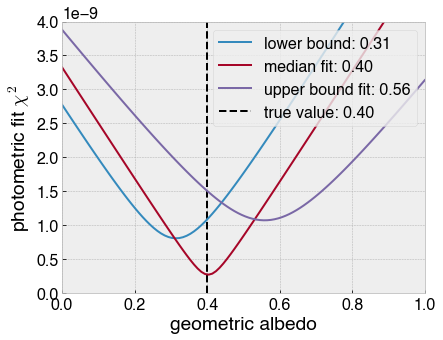

In [38]:
ymax = 4E-9

plt.figure(figsize=(6.5, 5))
plt.plot(albedos_test, fluxratio_chi2_minalbedo)
plt.plot(albedos_test, fluxratio_chi2_med)
plt.plot(albedos_test, fluxratio_chi2_maxalbedo)

plt.vlines(planetc.albedo_vals[0], 0, ymax, linestyles='dashed', color='k')

plt.legend(['lower bound: {:.2f}'.format(albedo_min),
            'median fit: {:.2f}'.format(albedo_med),
            'upper bound fit: {:.2f}'.format(albedo_max),
            'true value: {:.2f}'.format(planetc.albedo_vals[0])],
           loc = 'upper right')

plt.ylim([0, ymax])
plt.xlim([0, 1.0])

plt.xlabel('geometric albedo')
plt.ylabel('photometric fit $\chi^2$')

plot_fname = os.path.join(
        plot_dir,
        "albedo_fit_{:d}epochs_RVpriors{:}_totorb{:06d}.png".format(
        num_epochs, apply_RV_priors, total_orbits))
plt.savefig(plot_fname, dpi=200)

### Tabulate mass, radius, and albedo estimates

In [39]:
planetc_massradiusalbedo_table_fname = os.path.join(
        data_dir,
        "planet_c_in-house_mass-radius-albedo_{:d}epochs_RVpriors{:}_totorb{:06d}.csv".format(
        num_epochs, apply_RV_priors, total_orbits))
planetc_massradiusalbedo_table = astropy.table.Table()

rowlabel_col = astropy.table.Table.Column(name = 'value',
                                          data = ["lower", "median", "upper"], dtype = str)

mplan_col = astropy.table.Table.Column(name = 'mass (M_jup)',
                                       data = [mplan_min.to(u.M_jup).value,
                                               mplan_med.to(u.M_jup).value,
                                               mplan_max.to(u.M_jup).value],
                                       dtype = float, format="{:.2f}")

Rplan_col = astropy.table.Table.Column(name = 'radius (M_jup)',
                                       data = [Rplan_bem_min.to(u.R_jup).value,
                                               Rplan_bem_med.to(u.R_jup).value,
                                               Rplan_bem_max.to(u.R_jup).value],
                                       dtype = float, format="{:.2f}")

albedo_col = astropy.table.Table.Column(name = 'albedo',
                                        data = [albedo_min,
                                                albedo_med,
                                                albedo_max],
                                       dtype = float, format="{:.2f}")

planetc_massradiusalbedo_table.add_column(rowlabel_col, index = 0)
planetc_massradiusalbedo_table.add_column(mplan_col, index = 1)
planetc_massradiusalbedo_table.add_column(Rplan_col, index = 2)
planetc_massradiusalbedo_table.add_column(albedo_col, index = 3)

planetc_massradiusalbedo_table.write(planetc_massradiusalbedo_table_fname, overwrite=True)
print("Wrote mass, radius, and albedo results to\n{:s}".format(planetc_massradiusalbedo_table_fname))

Wrote mass, radius, and albedo results to
results/planet_c_in-house_mass-radius-albedo_5epochs_RVpriorsTrue_totorb040000.csv


In [40]:
planetc_massradiusalbedo_table

value,mass (M_jup),radius (M_jup),albedo
str6,float64,float64,float64
lower,0.85,0.91,0.31
median,1.00,0.96,0.40
upper,1.19,1.00,0.56


### Visualize fit to phase function

In [41]:
delta_dates

[<Quantity 0. yr>,
 <Quantity 0.15000684 yr>,
 <Quantity 1. yr>,
 <Quantity 2. yr>,
 <Quantity 3. yr>]

In [42]:
def get_fluxratio_curve(albedo, planet, times):
    tseries, delx, dely, beta, phasefunc, orad = planet.compute_ephem(tarray = times)
    fluxratio_curve = phasefunc * albedo * (planet.radius.to(u.AU) / orad)**2
    return fluxratio_curve

In [43]:
plot_times = np.linspace(-2, 12, 100) * u.year

fluxratio_curve_med = get_fluxratio_curve(albedo_med, planet_med, plot_times)
fluxratio_curve_minalbedo = get_fluxratio_curve(albedo_min, planet_minalbedo, plot_times)
fluxratio_curve_maxalbedo = get_fluxratio_curve(albedo_max, planet_maxalbedo, plot_times)

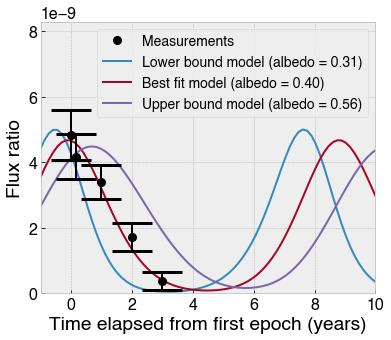

In [44]:
planetc_photo_fit_plot_fname = os.path.join(
        plot_dir,
        "planet_c_in-house_photometric-fit_{:d}epochs_RVpriors{:}_totorb{:06d}.png".format(
        num_epochs, apply_RV_priors, total_orbits))

delta_date_array = np.array([date.value for date in delta_dates])

plt.figure(figsize=(6,5))

min_curve = plt.plot(plot_times, fluxratio_curve_minalbedo)
med_curve = plt.plot(plot_times, fluxratio_curve_med)
max_curve = plt.plot(plot_times, fluxratio_curve_maxalbedo)

data_pts = plt.errorbar(delta_date_array, fluxratio_meas, yerr = fluxratio_meas_errs,
                        color='k', capsize=20, capthick=3, linestyle='',
                        marker='.', markersize=16, zorder=99)

plt.ylim([0, 8.3E-9])
plt.xlim([-1, 10.0])

plt.legend((data_pts[0], min_curve[0], med_curve[0], max_curve[0]),
           ('Measurements',
            'Lower bound model (albedo = {:.2f})'.format(albedo_min),
            'Best fit model (albedo = {:.2f})'.format(albedo_med),
            'Upper bound model (albedo = {:.2f})'.format(albedo_max)),
            fontsize=14)

plt.ylabel('Flux ratio')
plt.xlabel('Time elapsed from first epoch (years)')

plt.savefig(planetc_photo_fit_plot_fname, dpi=200)

In [45]:
data_pts[0]